In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

path_to_dataset_folder = '/content/drive/MyDrive/Documents/5.Work/5. UrDoer - 6 Mar 2023/10.1800 - Deep Learning/test'
batch_size = 32
img_height, img_width = 128, 128
test_ratio = 0.2

datagen = ImageDataGenerator(rescale=1./255, validation_split=test_ratio)

print("training data:")
train_data = datagen.flow_from_directory(
    path_to_dataset_folder,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

print("test data:")
test_data = datagen.flow_from_directory(
    path_to_dataset_folder,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

training data:
Found 240 images belonging to 10 classes.
test data:
Found 60 images belonging to 10 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

num_classes = len(train_data.class_indices)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 30
history = model.fit(train_data, epochs=epochs, validation_data=test_data)


Epoch 1/30
8/8 [==============================] - 17s 2s/step - loss: 2.3907 - accuracy: 0.1125 - val_loss: 2.2889 - val_accuracy: 0.1000
Epoch 2/30
8/8 [==============================] - 16s 2s/step - loss: 2.2747 - accuracy: 0.1417 - val_loss: 2.2252 - val_accuracy: 0.1333
Epoch 3/30
8/8 [==============================] - 16s 2s/step - loss: 2.1628 - accuracy: 0.1833 - val_loss: 2.1810 - val_accuracy: 0.1833
Epoch 4/30
8/8 [==============================] - 15s 2s/step - loss: 2.1004 - accuracy: 0.2458 - val_loss: 2.0757 - val_accuracy: 0.3500
Epoch 5/30
8/8 [==============================] - 15s 2s/step - loss: 1.9632 - accuracy: 0.2958 - val_loss: 1.8779 - val_accuracy: 0.3500
Epoch 6/30
8/8 [==============================] - 16s 2s/step - loss: 1.7821 - accuracy: 0.3833 - val_loss: 1.8692 - val_accuracy: 0.3667
Epoch 7/30
8/8 [==============================] - 16s 2s/step - loss: 1.6817 - accuracy: 0.4292 - val_loss: 1.7563 - val_accuracy: 0.4333
Epoch 8/30
8/8 [==================

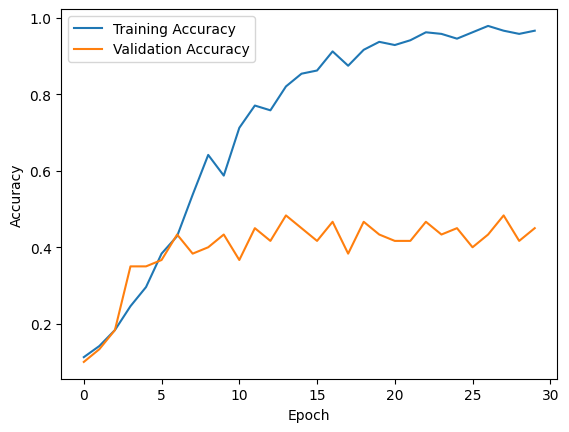

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_accuracy(history)

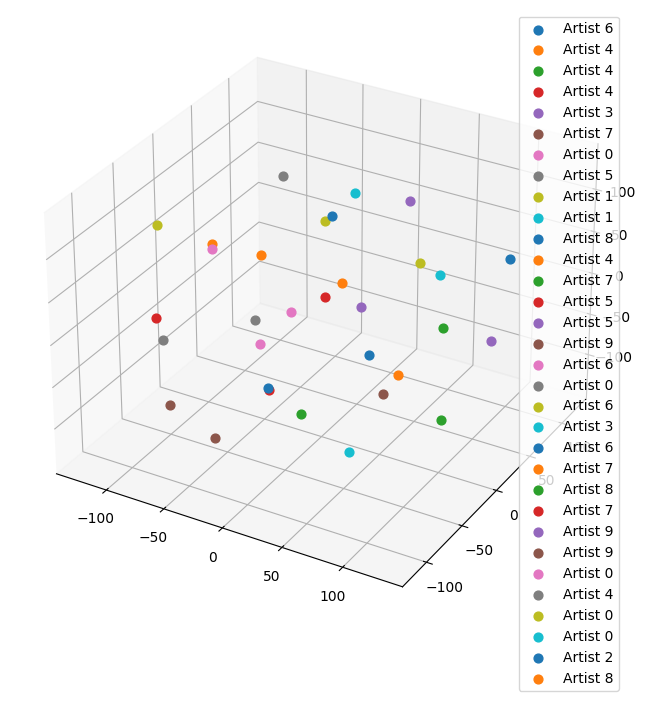

In [ ]:
from sklearn.manifold import TSNE

# Load the test images and their corresponding labels.
X_test, y_test = next(test_data)

# Project the images to 3-D using t-SNE.
tsne = TSNE(n_components=3, random_state=42)
X_3d = tsne.fit_transform(X_test.reshape(X_test.shape[0], -1))

# Visualize the 3-D projection.
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
for i, label in enumerate(np.argmax(y_test, axis=1)):
    ax.scatter(X_3d[i, 0], X_3d[i, 1], X_3d[i, 2], label=f'Artist {label}', s=40)
plt.legend()
plt.show()


In [ ]:
#Replace the folder names with these label names
artist_ids = [name.split('_')[-1] for name in test_data.class_indices.keys()]
print(artist_ids)

['Sisley', 'Modigliani', 'Degas', 'Picasso', 'Gauguin', 'Renoir', 'Rembrandt', 'Magritte', 'Titian', 'Gogh']


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def find_similar_images(test_image_path, k=3):
    # Load the test image and preprocess it.
    test_image = tf.keras.preprocessing.image.load_img(test_image_path, target_size=(img_height, img_width))
    test_image_array = tf.keras.preprocessing.image.img_to_array(test_image) / 255.0
    test_image_array = np.expand_dims(test_image_array, axis=0)

    # Get the embeddings for the test image.
    test_embedding = model.predict(test_image_array)

    # Find the cosine similarity between the test image and all other images in the test folder.
    artist_folder = os.path.dirname(test_image_path)
    similar_images = []

    for image_name in os.listdir(artist_folder):
        if image_name != os.path.basename(test_image_path):
            image_path = os.path.join(artist_folder, image_name)
            image_array = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_height, img_width))
            image_array = tf.keras.preprocessing.image.img_to_array(image_array) / 255.0
            image_array = np.expand_dims(image_array, axis=0)

            # Get the embeddings for the current image.
            image_embedding = model.predict(image_array)

            # Compute the cosine similarity.
            similarity = cosine_similarity(test_embedding, image_embedding)[0][0]
            similar_images.append((image_path, similarity))

    # Sort the similar images based on similarity score.
    similar_images.sort(key=lambda x: x[1], reverse=True)

    # Select the top k similar images.
    top_k_similar_images = [image_path for image_path, _ in similar_images[:k]]

    return top_k_similar_images

# Step 6 and Step 7: Find and plot the three closest images for each artist.
def plot_similar_images(test_folder):
    for artist_folder in os.listdir(test_folder):
        # Get the path to the first image in the artist's folder.
        first_image_path = os.path.join(test_folder, artist_folder, os.listdir(os.path.join(test_folder, artist_folder))[0])

        # Find the three closest images to the first image.
        similar_images = find_similar_images(first_image_path)

        # Plot the images.
        fig, axes = plt.subplots(1, 4, figsize=(15, 4))
        axes[0].imshow(tf.keras.preprocessing.image.load_img(first_image_path, target_size=(img_height, img_width)))
        axes[0].axis('off')
        for i, similar_image_path in enumerate(similar_images):
            axes[i+1].imshow(tf.keras.preprocessing.image.load_img(similar_image_path, target_size=(img_height, img_width)))
            axes[i+1].axis('off')
        plt.show()

In [ ]:
# Get the path to the test folder containing images of different artists.
test_folder = os.path.join(path_to_dataset_folder)

# Find and plot the three closest images for each artist.
for _ in range(9):
    plot_similar_images(test_folder)

Output hidden; open in https://colab.research.google.com to view.